<a href="https://colab.research.google.com/github/jihyunjeongme/data-analysis-kaggle/blob/master/%5BKaggle_2019_3rd_ML_month_with_KaKR%5D_%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%85%8B%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%B0%A8%EC%A2%85%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 필사 출처:
# https://www.kaggle.com/yangsaewon/pytorch-baseline-updated-7-10
# https://www.kaggle.com/fulrose/3rd-ml-month-car-model-classification-baseline

In [2]:
# 파이토치 사용하기
# 참고: https://medium.com/hyunjulie/구글-colab-에서-pytorch-사용하기-e065902d4a91

!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

     |████████████████████████████████| 592.3MB 1.6MB/s 
ERROR: torchvision 0.3.0 has requirement torch>=1.1.0, but you'll have torch 0.3.0.post4 which is incompatible.
ERROR: fastai 1.0.57 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0
     |████████████████████████████████| 748.9MB 26kB/s 
  Found existing installation: torch 0.3.0.post4
    Uninstalling torch-0.3.0.post4:
      Successfully uninstalled torch-0.3.0.post4


In [3]:
import gc
import os
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras import backend as K
warnings.filterwarnings(action='ignore')

K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [33]:
# test, traing set 데이터 불러오기

from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [34]:
cd /content/gdrive/My Drive/Colab Notebooks/dataanalysis/kaggle/2019_3rd_image_car_KaKR

/content/gdrive/My Drive/Colab Notebooks/dataanalysis/kaggle/2019_3rd_image_car_KaKR


## Preparation for the Data

### 파일 세부 설명
아래는 각 파일 별 세부 설명 입니다.

- train.csv - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- test.csv - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- submission.csv - Test셋과 대응되는 제출 파일
- class.csv - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
- train.zip - Train 이미지 파일
- test.zip - Test 이미지 파일



In [6]:
DATA_PATH = './'
os.listdir(DATA_PATH)

['sample_submission.csv',
 'test.zip',
 'test.csv',
 'train.zip',
 'train.csv',
 'class.csv',
 '2019-3rd-ml-month-with-kakr.zip',
 '2019-3rd-ml-month-with-kakr',
 'train',
 'test']

In [0]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

# **Data Exploration**  
---
- 실제 데이터가 Description과 일치하는지, 데이터는 어떻게 구성되어 있고 크랠스 별로 어떤 분포를 가지고 있는지 등 데이터에 전반적으로 살펴봄


---
## Check Data
### 컬럼 세부 설명
각 컬럼 별 세부 설명 입니다.

- img_file - 데이터 셋의 각 로우와 연결되는 이미지 파일 이름
- bbox_x1 - 바운딩 박스 x1 좌표 (좌상단 x)
- bbox_y1 - 바운딩 박스 y1 좌표 (좌상단 y)
- bbox_x2 - 바운딩 박스 x2 좌표 (우하단 x)
- bbox_y2 - 바운딩 박스 y2 좌표 (우하단 y)
- class - 예측하려는 차종(Target)
- id - 각 데이터 셋에 기입 되어 있는 클래스 id
- name - 클래스 id에 대응되는 실제 차종 레이블

In [8]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,train_00001.jpg,1,80,641,461,108
1,train_00002.jpg,57,53,293,236,71
2,train_00003.jpg,35,42,227,160,76
3,train_00004.jpg,10,21,254,165,188
4,train_00005.jpg,1,67,772,573,44


In [9]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,test_00001.jpg,199,184,1116,809
1,test_00002.jpg,55,61,480,257
2,test_00003.jpg,42,123,602,413
3,test_00004.jpg,13,8,619,393
4,test_00005.jpg,8,9,209,93


In [10]:
# 데이터 누락 체크

if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)):
  print("Train file 누락 없음")
else :
  print("Train file 누락")
  
if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음
Test file 누락 없음!


In [11]:
# Data 갯수
print("Number of Train Data: {}".format(df_train.shape[0]))
print("Number of Test Data: {}".format(df_test.shape[0]))

Number of Train Data: 9990
Number of Test Data: 6150


In [12]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [13]:
print("타켓 클래스 총 갯수: {}".format(df_class.shape[0]))
print("Train Data의 타겟 종류 갯수: {}".format(df_train['class'].nunique()))

타켓 클래스 총 갯수: 196
Train Data의 타겟 종류 갯수: 196


# Class Distribution
- 분류 문제에서 가장 먼저 의심해봐야 할 부분이 바로 Target Class의 분포 입니다. 학습에 사용해야 하는 Train Set의 타겟 분포를 확인해서 밸런스가 어느정도인지 체크해야 합니다.

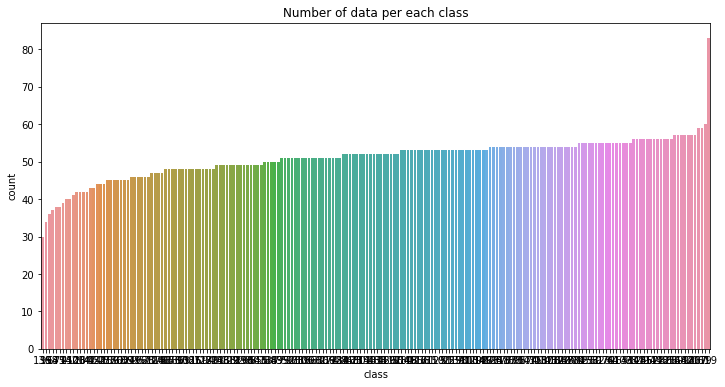

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()


In [20]:
cntEachClass = df_train["class"].value_counts(ascending=False)

print("Class with most count: {}".format(cntEachClass.index[0]))
print("Most Count: {}".format(cntEachClass.max()))

print("Class with fewest count: {}".format(cntEachClass.index[-1]))
print("Fewest Count: {}".format(cntEachClass.min()))

print("Mean : {}".format(cntEachClass.mean()))

Class with most count: 119
Most Count: 83
Class with fewest count: 136
Fewest Count: 30
Mean : 50.96938775510204


In [21]:
cntEachClass.describe()

count    196.000000
mean      50.969388
std        5.374115
min       30.000000
25%       48.000000
50%       52.000000
75%       54.000000
max       83.000000
Name: class, dtype: float64

In [0]:
# 대체적으로 카운트수는 비슷합니다. 84번째 클래스가 유독 카운트 숫자가 높고 평균은 51정도 입니다.

# Image Visualization
- 파이썬 커널에서 이미지를 보고 싶을땐 어떻게 할까요? 이미지를 로드하는 방법은 여러 방법이 있지만, 이 커널에서는 PIL 라이브러리를 사용합니다.
- Documentation: https://pillow.readthedocs.io/en/stable/


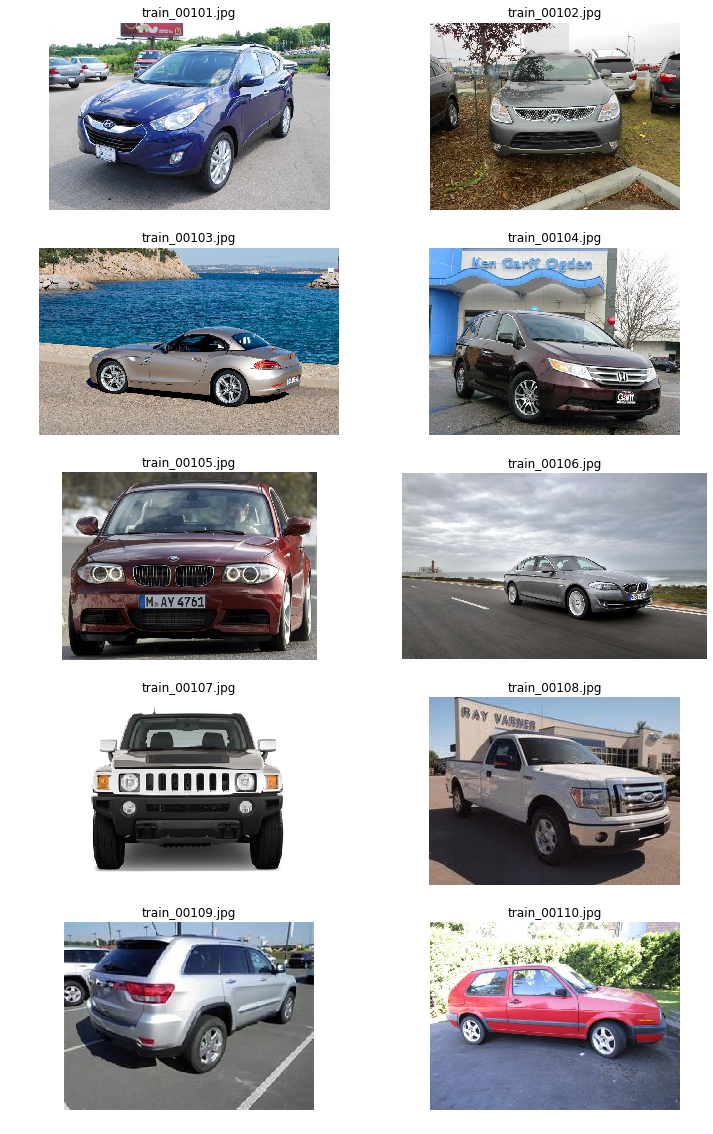

In [24]:
import PIL
from PIL import ImageDraw

tmp_imgs = df_train['img_file'][100:110]
plt.figure(figsize=(12, 20))

for num, f_name in enumerate(tmp_imgs):
  img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
  plt.subplot(5,2, num+1)
  plt.title(f_name)
  plt.imshow(img)
  plt.axis('off')

# Bounding Box
- 이미지 대회를 처음 해보시는 분이라면, 이 바운딩 박스라는 것이 생소
- 바운딩 박스란?
  - 이미지 내부에서 특정 Object를 박스로 레이블한 좌표를 말하며, 보통 좌측 상단(x1, y1)과 우측 하단(x2, y2)좌표가 주어져서 직사각형 모양의 박스를 그릴 수 있게 됩니다. 이때, 좌표는 이미지의 픽셀 좌표입니다.

In [0]:
def draw_rect(drawcontext, pos, outline=None, width=0):
  (x1, y1) = (pos[0], pos[1])
  (x2, y2) = (pos[2], pos[3])
  points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
  drawcontext.line(points, fill=outline, width=width)
  
def make_boxing_img(img_name) :
  if img_name.split('_')[0] == "train":
    PATH = TRAIN_IMG_PATH
    data = df_train
  elif img_name.split('_')[0] == "test":
    PATH = TEST_IMG_PATH
    data = df_test
    
  img = PIL.Image.open(os.path.join(PATH, img_name))
  pos = data.loc[data["img_file"] == img_name, \
                ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
  
  draw = ImageDraw.Draw(img)
  draw_rect(draw, pos, outline='red', width=10)
  
  return img         

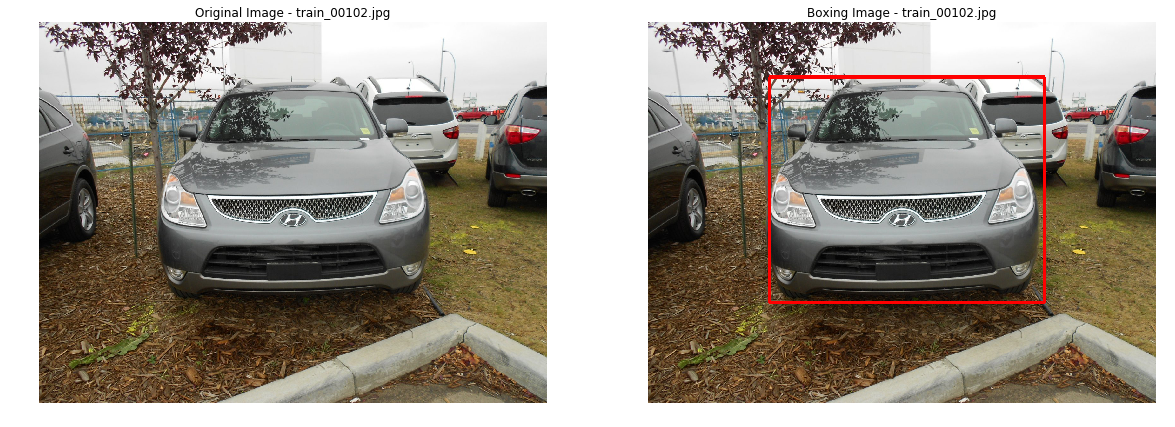

In [27]:
f_name = "train_00102.jpg"

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)

# Original Image
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

# Image included bounding box
plt.subplot(1,2,2)
boxing = make_boxing_img(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()


In [0]:
# 왼쪽 그림과 같이 어떤 이미지 내가 필요로하는 Target Object 뿐만 아니라 상관없는 다른 Object(Noise)가 
# 섞여 있을 수 있습니다. 이런 경우에 이미지 내부에서 필요한 Object를 명확히 표시하기 위해 Bounding Box를 사용
# (실제로 이미지를 모델에 넣을때는 Box 바깥 부분은 잘라서 사용합니다.)

# 이번 대회는 Bounding Box 좌표가 이미 주어져 있습니다. 만약 Bounding Box 좌표가 주어지지 않는 다면
# 직접 레이블을 하거나, Bounding box의 좌표를 예측하는 딥러닝 모델을 설계해볼 수도 있습니다.

# 이번 커널에서는 바운딩박스를 활용하지 않습니다. 하지만, 꼭 구현해보길 권장합니다.

# Model
- 이제 본격적으로 이미지 분류 모델을 만들어봅시다.
- 이번 커널에서는 ResNet50 Pretrained Model을 불러와서 사용합니다.

## Train set, valid set split
- 모델 학습을 하기전에 주어진 Train 데이터 셋을 어떻게 활용할 지 생각해야 합니다.

<img src = "https://t1.daumcdn.net/cfile/tistory/9951E5445AAE1BE025">

- 일반적으로, 주어진 Train 데이터를 위와 같이 Train/Validation으로 나누는 작업을 진행합니다.
-Test 데이터가 검증을 위한 데이터 셋
- Training 데이터로 모델을 만들고 Test 데이터로 확인하면 되는 것
- 캐글에서 높은 점수를 받기 위해 Cross Validation set을 구성
- 이번 커널에서는 Cross validation을 따로 만들진 않음.
- CV: Cross validation 점수
- LB: Leader board에 올라간 Public Score

## Train_test_split

In [30]:

# 사이킷런읜 train_test_split 함수를 활용하여 Train 셋을 Train/ Validation 셋으로 나눔
# 특정 array를 원하는 비율로 나눔

from sklearn.model_selection import train_test_split

df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)


(7992, 2)
(1998, 2)
(6150, 1)


## Generator
- 이미지 프로세싱에서 없어서는 안될 필수 과정

### Generator의 이점
- 제너레이터는 코랩이나 캐글 커널같은 클라우드 환경 또는 일반적인 로컬 환경에서 정말 유용하게 쓰일 수 있습니다. 그 이유는 보통 이러한 환경은 메모리가 충분하지 않기 때문이죠. 특히나 이미지 처럼 파일하나의 용량이 매우 큰 경우, 한번에 모든 파일을 메모리에 적재하게 되면 상당히 큰 부담이 됩니다. 배치사이즈 단위 만큼 파일을 불러와 학습하고 끝나면 다시 불러와서 학습하는 방법을 반복하기 때문에 전체 학습을 하더라도 메모리를 조금만 사용하게 되는 것입니다.

### Keras DataGenerator
- 지금껏 불편하게 제너레이터를 만들어 사용했다면 케라스에는 정말 편한 제너레이터 함수가 있습니다. 케라스 ImageDataGenerator는 제너레이터의 기능은 물론 제너레이터를 정의하면서 동시에 Data에 원하는 Noise까지 부여할 수 있습니다. 또한 Documentaion을 참고하시면 생각보다 많은 기능이 있으니 이번 기회에 한번 사용해 보시는 것도 좋을 것 같네요.

- Documentaion : https://keras.io/preprocessing/image/
- 이번 커널에서는 케라스 내부의 DataGenerator를 사용합니다. 하지만, 주어진 데이터가 이미지가 아닌 경우에는 제너레이터를 직접 설계해야 하는 경우도 있습니다. 그러니 케라스 제너레이터에 너무 익숙해지는 것 보다는 직접 제너레이터를 설계해보는 것도 강력히 추천합니다!

In [44]:
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

# Parameter
img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

# Define Generator config
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = False,
    zoom_range = 0.10,
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory='./train/',
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory='./train',
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory='./test',
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 7992 validated image filenames belonging to 196 classes.
Found 1998 validated image filenames belonging to 196 classes.
Found 6150 validated image filenames.


### Loading Pretrained Model - ResNet50
<img src="https://cdn-images-1.medium.com/max/987/1*pUyst_ciesOz_LUg0HocYg.png">

그 유명한 ResNet입니다. Residual(잔차)를 이용한 획기적인 모델로 평가됩니다. 보통 딥러닝 모델을 구성할 때 직접 만들어 보는것도 좋지만, 이 작업은 상당히 많은 시간과 노력이 필요하기 때문에, 이미 성능이 입증된 모델을 불러와서 사용해보는 것도 좋은 방법이죠.

Pretrained Model을 불러오기 위해서는 커널의 Internet 옵션이 활성화 되어 있어야 합니다.

ResNet arxiv : http://www.arxiv.org/abs/1512.03385

In [0]:
resNet_model = ResNet50(include_top=False, input_shape = (224,224,3))

In [46]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

# for layer in resNet_model.layers:
#     layer.trainable = False
#     print(layer, layer.trainable)

model = Sequential()
model.add(resNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               401604    
Total params: 23,989,316
Trainable params: 23,936,196
Non-trainable params: 53,120
_________________________________________________________________


Pretrained Model을 사용할 때 한가지 주의할 점이 있습니다. Pretrained 모델은 경우에 따라 다양하게 사용될 수 있기 때문에 Model output부분을 잘라버린 채 로드 되는 경우가 있습니다.(include_top=False) 이 경우에는 직접 output을 만들어야 되겠죠? 우리는 196개의 class를 분류하기 때문에 위와 같이 만들었습니다.

참고)
케라스에는 모델을 생성하는 방법이 2가지가 있습니다. 하나는 위처럼 Sequential을 사용하는 것이고 하나는 Model을 사용하는 방법입니다. 2가지 모두 많이 사용하니 Model도 한번 사용해보세요.

### Model Compile
이제 Model을 만들었으니 어떻게 학습할 지 정해야 합니다. 어떤 방법으로, 어떤 속도로, 어떤 지표를 기준으로 등등 정할 수 있고 필요시에는 각각의 함수를 직접 구현해볼 수도 있습니다. 하지만, 보통은 기본으로 주어지는 것들을 사용합니다.

In [0]:
from sklearn.metrics import f1_score

def micro_f1(y_true, y_pred):
  return f1_score(y_true, y_pred, average='micro')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])



## Model Training
- 이제 진짜 학습을 해봅시다. 시간이 소요되니 커피한잔

In [0]:
def get_steps(num_samples, batch_size):
  if(num_samples % batch_size) > 0 :
    return (num_samples // batch_size) + 1
  else:
    return num_samples // batch_size

In [50]:
%%time
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = "my_resnet_model_{val_acc:.2f}_{val_loss:.4f}.h5"

# ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')

callbackList = [es]

history = model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size),
    callbacks = callbackList

)
gc.collect()

W0818 09:09:06.560606 140588076971904 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
 12/250 [>.............................] - ETA: 43:45 - loss: 5.7272 - acc: 0.0104

KeyboardInterrupt: ignored

## Training History Visualization
- 학습된 결과를 plot으로 그려 볼 수 있습니다. 모델 학습 로그를 통해서 확인할 수도 있지만, 전반적인 학습형태를 한눈에 파악할 수 있습니다.